In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random


from collections import Counter
from scipy.stats import mode

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
full_model_path =  r'C:\Users\k54739\saved_model\ohneContrastSweetcrop_simclr_model_epoch_245.pth' 

In [5]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [6]:
simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4,max_epochs=245)
simclr_model.load_state_dict(torch.load(full_model_path))
simclr_model.to(device)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_28352\1467178467.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(full_model_path))


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [7]:
from torchvision.transforms import Resize

# order of data aug is important. first should be resize to 96*96

### Simclr feature Encoder-decoder


In [8]:
class ImageDataset(Dataset):
    def __init__(self, day7_dir, transform=None):
        self.day7_files = [os.path.join(day7_dir, file) for file in os.listdir(day7_dir) if file.endswith(('.tiff', '.tif'))]
        self.resize = Resize((96, 96))
        self.transform = transform  # Optional: Add transformations if needed

    def __len__(self):
        return len(self.day7_files)

    def __getitem__(self, idx):
        day7_img_path = self.day7_files[idx]

        # Load the Day7 image
        day7_img = tiff.imread(day7_img_path)

        # Ensure the image has 3 layers (channels)
        if day7_img.shape[0] != 3:
            raise ValueError(f"Day7 image at {day7_img_path} does not have exactly 3 layers. Found shape: {day7_img.shape}.")

        # Normalize and convert the image
        day7_img = day7_img.astype(np.float32) / 65535.0
        day7_img = torch.tensor(day7_img, dtype=torch.float32)

        # Resize the image
        day7_img = self.resize(day7_img)

        # Apply any additional transformations if provided
        if self.transform:
            day7_img = self.transform(day7_img)

        return day7_img, day7_img_path  # Optionally include the image path for reference

aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomAdjustSharpness(sharpness_factor=2.0, p=1),
    transforms.RandomApply([
        transforms.GaussianBlur(5, sigma=(0.1, 1)) #std p= 0.5 .simclr randomly sample σ ∈ [0.1, 2.0], and the kernel size is set to be 10% of the image height/width. # 9 is the 10% of hight (96) since resizecrop to 96 already loosing info, i wanna reduce bluring. less kernal size and less  less blur
    ], p=1),
    transforms.RandomApply([
    transforms.ColorJitter(brightness=0.15)
    ], p=1), 

])




In [ ]:
# Specify paths for both day7 and day10 folders
orig_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7today7\control_d7\orig_combined'
aug_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day7today7\control_d7\aug_combined'


# Create the dataset
orig_dataset = ImageDataset(orig_dir,transform=None) 
aug_dataset = ImageDataset(aug_dir,transform=aug_transform) 

# shuffle = false because we are extracting features not training

In [9]:
batch_size = 16
# Define DataLoaders
orig_loader = DataLoader(orig_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu
aug_loader = DataLoader(aug_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu

# Retrieve one dataset sample
day7_img, day7_img_path = orig_dataset[0]  # Access the first image in the dataset

# Check the tensor values
print(f"Image path: {day7_img_path}")
print(f"Image tensor shape: {day7_img.shape}")  # Should be (3, H, W)
print("Image data (normalized):")
print(day7_img)  # Print the tensor values

# Check min, max, and mean to confirm normalization
print(f"Min value: {day7_img.min().item()}")
print(f"Max value: {day7_img.max().item()}")
print(f"Mean value: {day7_img.mean().item()}")


In [10]:
# Calculate the total number of images in the training dataset
total_images_in_orig = len(orig_loader.dataset)
print(f"Total number of images: {total_images_in_orig}")

Total number of images: 472


In [11]:
# Calculate the total number of images in the training dataset
total_images_in_aug = len(aug_loader.dataset)
print(f"Total number of images: {total_images_in_aug}")

Total number of images: 472


In [12]:
for i, (image, image_path) in enumerate(orig_loader):  # Unpack the returned tuple
    print(f"Batch {i + 1}:")
    print(f"  Image: {image.shape}")  # Shape of the batch of images
    print(f"  Paths: {image_path[:3]}")  # Print first 3 paths for reference
    break  # Process only the first batch for demonstration

Batch 1:
  Image: torch.Size([16, 3, 96, 96])
  Paths: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\day7today7\\control_d7\\orig_combined\\ds_1B_B02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\day7today7\\control_d7\\orig_combined\\ds_1B_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\day7today7\\control_d7\\orig_combined\\ds_1B_B04-T01.tiff']


In [13]:
for i, (aug, aug_path) in enumerate(aug_loader):  # Unpack the returned tuple
    print(f"Batch {i + 1}:")
    print(f"  Image: {aug.shape}")  # Shape of the batch of images
    print(f"  Paths: {aug_path[:3]}")  # Print first 3 paths for reference
    break  # Process only the first batch for demonstration

Batch 1:
  Image: torch.Size([16, 3, 96, 96])
  Paths: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\day7today7\\control_d7\\aug_combined\\aug_ds_1B_B02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\day7today7\\control_d7\\aug_combined\\aug_ds_1B_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\day7today7\\control_d7\\aug_combined\\aug_ds_1B_B04-T01.tiff']


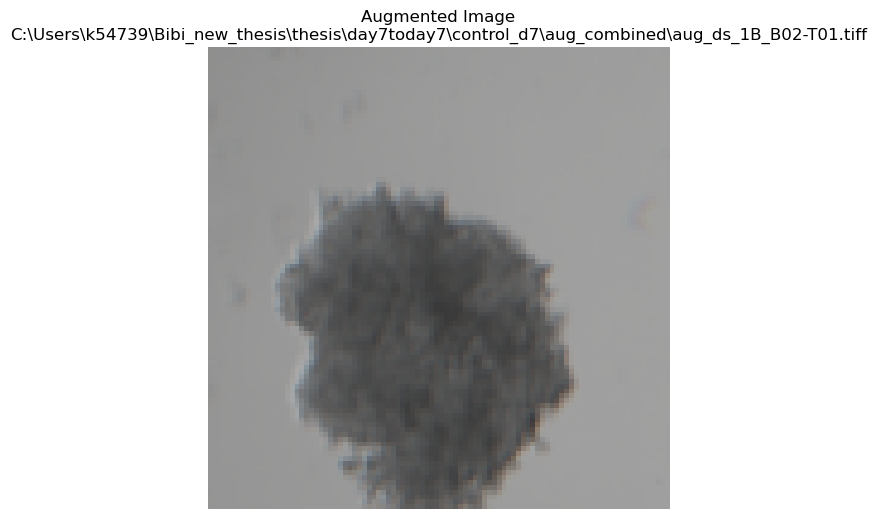

In [14]:
import matplotlib.pyplot as plt

# Retrieve a batch of augmented images
for batch_imgs, batch_paths in aug_loader:
    # Visualize the first image in the batch
    aug_img = batch_imgs[0].permute(1, 2, 0).numpy()  # Convert (C, H, W) to (H, W, C)
    #aug_img = (aug_img * 255).astype(np.uint8)  # Scale to [0, 255] for visualization

    # Display the augmented image
    plt.figure(figsize=(6, 6))
    plt.imshow(aug_img)
    plt.title(f"Augmented Image\n{batch_paths[0]}")
    plt.axis("off")
    plt.show()

    break  # Display only the first batch for demonstration


torch.Size([3, 96, 96])
(96, 96, 3)


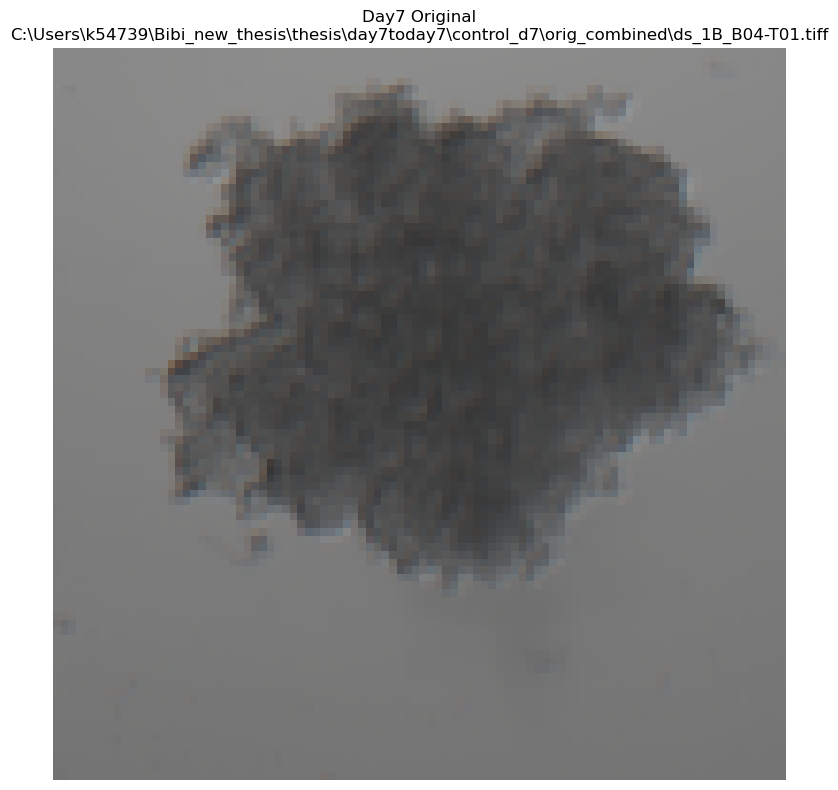

In [15]:
import matplotlib.pyplot as plt

# Retrieve one dataset sample
day7_img, day7_img_path = orig_dataset[2]
print(day7_img.shape)
# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
print(day7_img_np.shape)   # Convert (C, H, W) to (H, W, C)

# Display the image with its path
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(1, 1, 1)
plt.imshow(day7_img_np)
plt.title(f"Day7 Original\n{day7_img_path}")
plt.axis("off")

plt.tight_layout()
plt.show()


torch.Size([3, 96, 96])
(96, 96, 3)


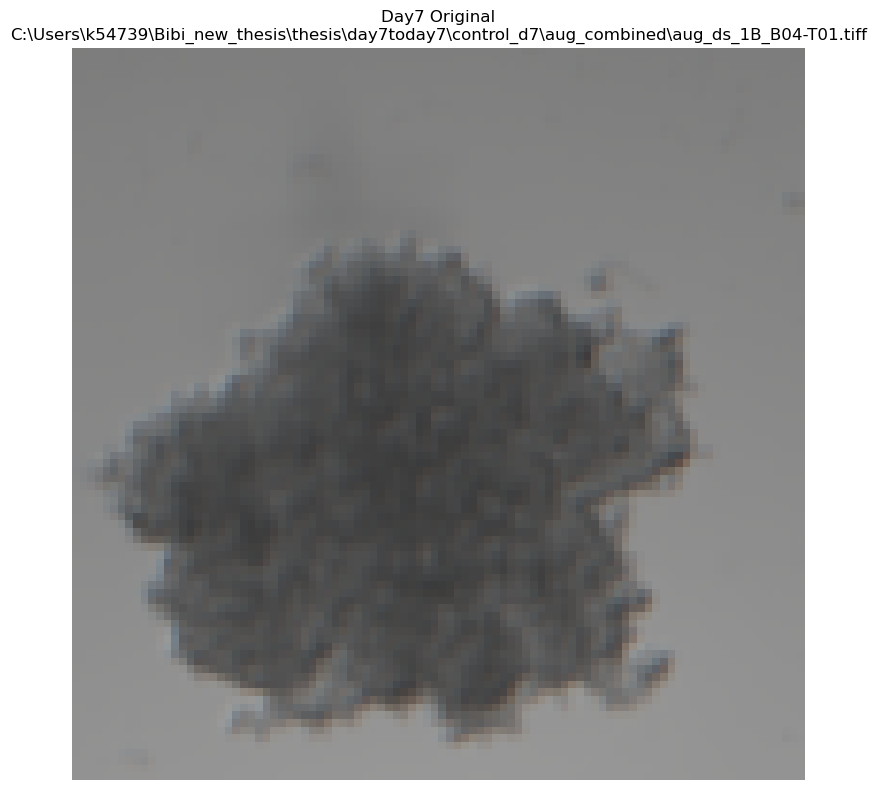

In [16]:
import matplotlib.pyplot as plt

# Retrieve one dataset sample
day7_img, day7_img_path = aug_dataset[2]
print(day7_img.shape)
# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
print(day7_img_np.shape)   # Convert (C, H, W) to (H, W, C)

# Display the image with its path
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(1, 1, 1)
plt.imshow(day7_img_np)
plt.title(f"Day7 Original\n{day7_img_path}")
plt.axis("off")

plt.tight_layout()
plt.show()


torch.Size([3, 96, 96])
(96, 96, 3)


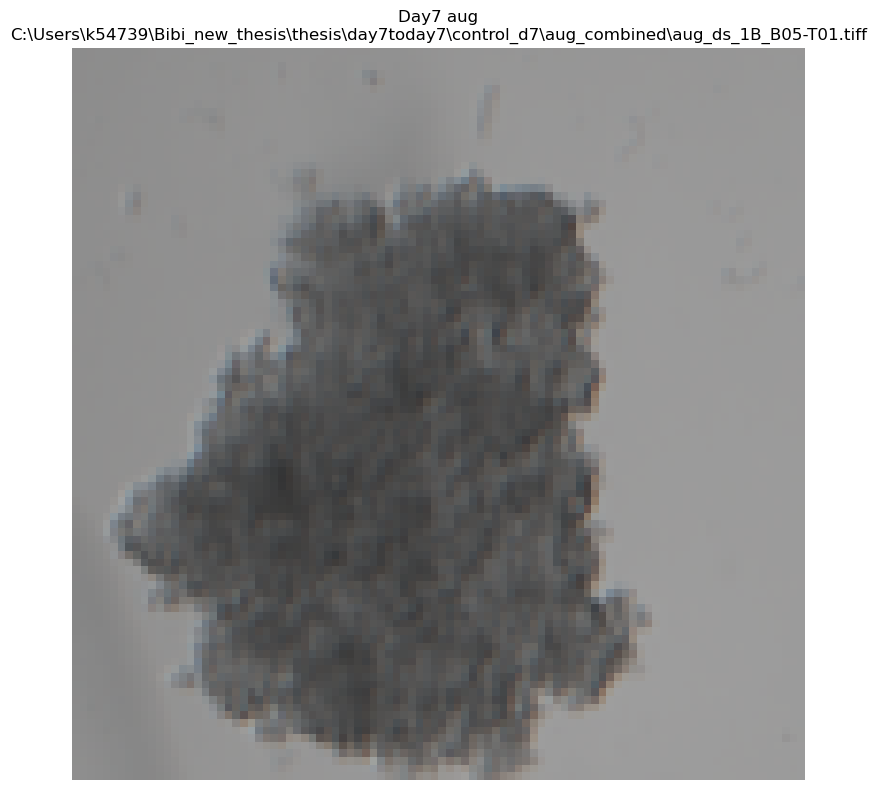

In [17]:
import matplotlib.pyplot as plt

# Retrieve one dataset sample
day7_img, day7_img_path = aug_dataset[3]
print(day7_img.shape)
# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
print(day7_img_np.shape)   # Convert (C, H, W) to (H, W, C)

# Display the image with its path
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(1, 1, 1)
plt.imshow(day7_img_np)
plt.title(f"Day7 aug\n{day7_img_path}")
plt.axis("off")

plt.tight_layout()
plt.show()


In [18]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    features = []
    image_paths = []

    for batch_imgs, batch_paths in tqdm(dataloader):
        # Move images to the device
        batch_imgs = batch_imgs.to(device)

        # Extract features
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")

        # Collect features and paths
        features.append(batch_feats.detach().cpu())
        image_paths.extend(batch_paths)  # Add the paths

    # Concatenate features
    features = torch.cat(features, dim=0)
    print(f"Features shape after concatenation: {features.shape}")

    return features, image_paths


In [19]:
# Assuming you have a pre-trained model and DataLoader
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Extract features from the training dataset
orig_image, orig_path = prepare_data_features(simclr_model, orig_loader)


# Use the extracted features for your MLP model training
# Example: MLP(input_dim=train_day7_feats.shape[1], output_dim=train_day10_feats.shape[1])


  3%|▎         | 1/30 [00:00<00:25,  1.12it/s]

Batch features shape: torch.Size([16, 512])


  7%|▋         | 2/30 [00:01<00:20,  1.34it/s]

Batch features shape: torch.Size([16, 512])


 10%|█         | 3/30 [00:02<00:18,  1.45it/s]

Batch features shape: torch.Size([16, 512])


 13%|█▎        | 4/30 [00:02<00:17,  1.51it/s]

Batch features shape: torch.Size([16, 512])


 17%|█▋        | 5/30 [00:03<00:16,  1.55it/s]

Batch features shape: torch.Size([16, 512])


 20%|██        | 6/30 [00:04<00:16,  1.50it/s]

Batch features shape: torch.Size([16, 512])


 23%|██▎       | 7/30 [00:04<00:15,  1.46it/s]

Batch features shape: torch.Size([16, 512])


 27%|██▋       | 8/30 [00:05<00:15,  1.42it/s]

Batch features shape: torch.Size([16, 512])


 30%|███       | 9/30 [00:06<00:15,  1.36it/s]

Batch features shape: torch.Size([16, 512])


 33%|███▎      | 10/30 [00:07<00:15,  1.31it/s]

Batch features shape: torch.Size([16, 512])


 37%|███▋      | 11/30 [00:08<00:14,  1.29it/s]

Batch features shape: torch.Size([16, 512])


 40%|████      | 12/30 [00:08<00:14,  1.27it/s]

Batch features shape: torch.Size([16, 512])


 43%|████▎     | 13/30 [00:09<00:13,  1.25it/s]

Batch features shape: torch.Size([16, 512])


 47%|████▋     | 14/30 [00:10<00:12,  1.23it/s]

Batch features shape: torch.Size([16, 512])


 50%|█████     | 15/30 [00:11<00:12,  1.20it/s]

Batch features shape: torch.Size([16, 512])


 53%|█████▎    | 16/30 [00:12<00:11,  1.18it/s]

Batch features shape: torch.Size([16, 512])


 57%|█████▋    | 17/30 [00:13<00:11,  1.16it/s]

Batch features shape: torch.Size([16, 512])


 60%|██████    | 18/30 [00:13<00:10,  1.17it/s]

Batch features shape: torch.Size([16, 512])


 63%|██████▎   | 19/30 [00:14<00:09,  1.18it/s]

Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 20/30 [00:15<00:08,  1.18it/s]

Batch features shape: torch.Size([16, 512])


 70%|███████   | 21/30 [00:16<00:07,  1.20it/s]

Batch features shape: torch.Size([16, 512])


 73%|███████▎  | 22/30 [00:17<00:06,  1.21it/s]

Batch features shape: torch.Size([16, 512])


 77%|███████▋  | 23/30 [00:18<00:05,  1.21it/s]

Batch features shape: torch.Size([16, 512])


 80%|████████  | 24/30 [00:18<00:04,  1.22it/s]

Batch features shape: torch.Size([16, 512])


 83%|████████▎ | 25/30 [00:19<00:04,  1.22it/s]

Batch features shape: torch.Size([16, 512])


 87%|████████▋ | 26/30 [00:20<00:03,  1.20it/s]

Batch features shape: torch.Size([16, 512])


 90%|█████████ | 27/30 [00:21<00:02,  1.15it/s]

Batch features shape: torch.Size([16, 512])


 93%|█████████▎| 28/30 [00:22<00:01,  1.18it/s]

Batch features shape: torch.Size([16, 512])


 97%|█████████▋| 29/30 [00:23<00:00,  1.22it/s]

Batch features shape: torch.Size([16, 512])


100%|██████████| 30/30 [00:23<00:00,  1.28it/s]

Batch features shape: torch.Size([8, 512])
Features shape after concatenation: torch.Size([472, 512])


In [20]:
aug_image, aug_path = prepare_data_features(simclr_model, aug_loader)

  3%|▎         | 1/30 [00:00<00:20,  1.42it/s]

Batch features shape: torch.Size([16, 512])


  7%|▋         | 2/30 [00:01<00:22,  1.25it/s]

Batch features shape: torch.Size([16, 512])


 10%|█         | 3/30 [00:02<00:21,  1.23it/s]

Batch features shape: torch.Size([16, 512])


 13%|█▎        | 4/30 [00:03<00:22,  1.15it/s]

Batch features shape: torch.Size([16, 512])


 17%|█▋        | 5/30 [00:04<00:22,  1.12it/s]

Batch features shape: torch.Size([16, 512])


 20%|██        | 6/30 [00:05<00:21,  1.11it/s]

Batch features shape: torch.Size([16, 512])


 23%|██▎       | 7/30 [00:06<00:21,  1.07it/s]

Batch features shape: torch.Size([16, 512])


 27%|██▋       | 8/30 [00:07<00:20,  1.09it/s]

Batch features shape: torch.Size([16, 512])


 30%|███       | 9/30 [00:07<00:18,  1.13it/s]

Batch features shape: torch.Size([16, 512])


 33%|███▎      | 10/30 [00:08<00:17,  1.15it/s]

Batch features shape: torch.Size([16, 512])


 37%|███▋      | 11/30 [00:09<00:15,  1.21it/s]

Batch features shape: torch.Size([16, 512])


 40%|████      | 12/30 [00:10<00:14,  1.23it/s]

Batch features shape: torch.Size([16, 512])


 43%|████▎     | 13/30 [00:11<00:13,  1.25it/s]

Batch features shape: torch.Size([16, 512])


 47%|████▋     | 14/30 [00:11<00:12,  1.24it/s]

Batch features shape: torch.Size([16, 512])


 50%|█████     | 15/30 [00:12<00:12,  1.21it/s]

Batch features shape: torch.Size([16, 512])


 53%|█████▎    | 16/30 [00:13<00:11,  1.21it/s]

Batch features shape: torch.Size([16, 512])


 57%|█████▋    | 17/30 [00:14<00:10,  1.24it/s]

Batch features shape: torch.Size([16, 512])


 60%|██████    | 18/30 [00:15<00:09,  1.27it/s]

Batch features shape: torch.Size([16, 512])


 63%|██████▎   | 19/30 [00:15<00:08,  1.31it/s]

Batch features shape: torch.Size([16, 512])


 67%|██████▋   | 20/30 [00:16<00:07,  1.28it/s]

Batch features shape: torch.Size([16, 512])


 70%|███████   | 21/30 [00:17<00:06,  1.31it/s]

Batch features shape: torch.Size([16, 512])


 73%|███████▎  | 22/30 [00:18<00:06,  1.32it/s]

Batch features shape: torch.Size([16, 512])


 77%|███████▋  | 23/30 [00:18<00:05,  1.29it/s]

Batch features shape: torch.Size([16, 512])


 80%|████████  | 24/30 [00:19<00:04,  1.32it/s]

Batch features shape: torch.Size([16, 512])


 83%|████████▎ | 25/30 [00:20<00:03,  1.29it/s]

Batch features shape: torch.Size([16, 512])


 87%|████████▋ | 26/30 [00:21<00:03,  1.30it/s]

Batch features shape: torch.Size([16, 512])


 90%|█████████ | 27/30 [00:22<00:02,  1.25it/s]

Batch features shape: torch.Size([16, 512])


 93%|█████████▎| 28/30 [00:22<00:01,  1.26it/s]

Batch features shape: torch.Size([16, 512])


 97%|█████████▋| 29/30 [00:23<00:00,  1.27it/s]

Batch features shape: torch.Size([16, 512])


100%|██████████| 30/30 [00:23<00:00,  1.25it/s]

Batch features shape: torch.Size([8, 512])
Features shape after concatenation: torch.Size([472, 512])


In [27]:
# Create labels to track the source of features
orig_labels = ["orig"] * len(orig_path)  # Label all original features as "orig"
aug_labels = ["aug"] * len(aug_path)    # Label all augmented features as "aug"

# Combine features, paths, and labels
combined_features = torch.cat([orig_image, aug_image], dim=0)
combined_paths = orig_path + aug_path  # Combine paths (list concatenation)
combined_labels = orig_labels + aug_labels  # Combine labels (list concatenation)

print(f"Combined features shape: {combined_features.shape}")
print(f"Number of combined paths: {len(combined_paths)}")
print(f"Number of combined labels: {len(combined_labels)}")


Combined features shape: torch.Size([944, 512])
Number of combined paths: 944
Number of combined labels: 944


In [40]:
import pandas as pd

# Convert features to list format for CSV
features_list = combined_features.numpy().tolist()  # Convert tensor to list

# Create a DataFrame
data = {
    "path": combined_paths,
    "label": combined_labels,
    "features": features_list,
}
df = pd.DataFrame(data)

# Save to CSV
df.to_csv("combined_features.csv", index=False)
print("Combined dataset saved to CSV successfully.")


Combined dataset saved to CSV successfully.


In [42]:
# Load the CSV file
df = pd.read_csv("combined_features.csv")

# Extract paths, labels, and features
loaded_paths = df["path"].tolist()
loaded_labels = df["label"].tolist()
loaded_features = torch.tensor(df["features"].apply(eval).to_list(), dtype=torch.float32)
print(df.head())
print(f"Loaded features shape: {loaded_features.shape}")
print(f"Loaded paths: {len(loaded_paths)}")
print(f"Loaded labels: {len(loaded_labels)}")


                                                path label  \
0  C:\Users\k54739\Bibi_new_thesis\thesis\day7tod...  orig   
1  C:\Users\k54739\Bibi_new_thesis\thesis\day7tod...  orig   
2  C:\Users\k54739\Bibi_new_thesis\thesis\day7tod...  orig   
3  C:\Users\k54739\Bibi_new_thesis\thesis\day7tod...  orig   
4  C:\Users\k54739\Bibi_new_thesis\thesis\day7tod...  orig   

                                            features  
0  [0.0, 1.7346123456954956, 0.44908469915390015,...  
1  [0.0, 0.0, 0.0, 3.3737080097198486, 0.04312886...  
2  [0.0, 0.018066002056002617, 0.0, 0.0, 0.081132...  
3  [0.0, 1.2526673078536987, 0.0, 0.0, 0.0, 0.071...  
4  [0.0, 3.4545886516571045, 0.2538684606552124, ...  
Loaded features shape: torch.Size([944, 512])
Loaded paths: 944
Loaded labels: 944


In [36]:
combined_paths[943]

'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\day7today7\\control_d7\\aug_combined\\aug_sd_04_G11-T01.tiff'

In [39]:
combined_labels[471]

'orig'

In [23]:
orig_image == aug_image

tensor([[ True, False, False,  ...,  True,  True, False],
        [ True,  True,  True,  ..., False,  True, False],
        [ True, False,  True,  ...,  True,  True, False],
        ...,
        [False, False, False,  ...,  True,  True, False],
        [False, False, False,  ...,  True,  True, False],
        [False, False, False,  ..., False, False, False]])

In [24]:
# Element-wise comparison
comparison_result = orig_image == aug_image  # Boolean tensor

# Extract the values where the comparison is True
true_values = orig_image[comparison_result]

# Find unique values
unique_true_values = torch.unique(true_values)

# Print results
print("Values that result in True:")
print(true_values)

print("\nUnique values among them:")
print(unique_true_values)


Values that result in True:
tensor([0., 0., 0.,  ..., 0., 0., 0.])

Unique values among them:
tensor([0.])


In [25]:
print(orig_image.shape)
print(aug_image.shape)

torch.Size([472, 512])
torch.Size([472, 512])


In [26]:
print(len(orig_path))
print(len(aug_path))

472
472


# inference to encode other classes

In [6]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random


from collections import Counter
from scipy.stats import mode
from torchvision.transforms import Resize

In [2]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
full_model_path =  r'C:\Users\k54739\saved_model\ohneContrastSweetcrop_simclr_model_epoch_245.pth' 

In [4]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [5]:
simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4,max_epochs=245)
simclr_model.load_state_dict(torch.load(full_model_path))
simclr_model.to(device)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_21320\1467178467.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(full_model_path))


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [7]:
class ImageDataset(Dataset):
    def __init__(self, day7_dir, transform=None):
        self.day7_files = [os.path.join(day7_dir, file) for file in os.listdir(day7_dir) if file.endswith(('.tiff', '.tif'))]
        self.resize = Resize((96, 96))
        self.transform = transform  # Optional: Add transformations if needed

    def __len__(self):
        return len(self.day7_files)

    def __getitem__(self, idx):
        day7_img_path = self.day7_files[idx]

        # Load the Day7 image
        day7_img = tiff.imread(day7_img_path)

        # Ensure the image has 3 layers (channels)
        if day7_img.shape[0] != 3:
            raise ValueError(f"Day7 image at {day7_img_path} does not have exactly 3 layers. Found shape: {day7_img.shape}.")

        # Normalize and convert the image
        day7_img = day7_img.astype(np.float32) / 65535.0
        day7_img = torch.tensor(day7_img, dtype=torch.float32)

        # Resize the image
        day7_img = self.resize(day7_img)

        # Apply any additional transformations if provided
        if self.transform:
            day7_img = self.transform(day7_img)

        return day7_img, day7_img_path 

In [40]:
inference_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\day10today10\wichtig3_channel\ds&sd_untreated'
inference_dataset = ImageDataset(inference_dir,transform=None) 

In [41]:
batch_size = 16
# Define DataLoaders
inference_loader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [42]:
# Calculate the total number of images in the training dataset
total_images_in_infer = len(inference_loader.dataset)
print(f"Total number of images: {total_images_in_infer}")

Total number of images: 199


In [43]:
for i, (aug, aug_path) in enumerate(inference_loader):  # Unpack the returned tuple
    print(f"Batch {i + 1}:")
    print(f"  Image: {aug.shape}")  # Shape of the batch of images
    print(f"  Paths: {aug_path[:3]}")  # Print first 3 paths for reference
    break  # Process only the first batch for demonstration

Batch 1:
  Image: torch.Size([16, 3, 96, 96])
  Paths: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\day10today10\\wichtig3_channel\\ds&sd_untreated\\ds_41_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\day10today10\\wichtig3_channel\\ds&sd_untreated\\ds_41_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\day10today10\\wichtig3_channel\\ds&sd_untreated\\ds_41_D09-T01.tiff']


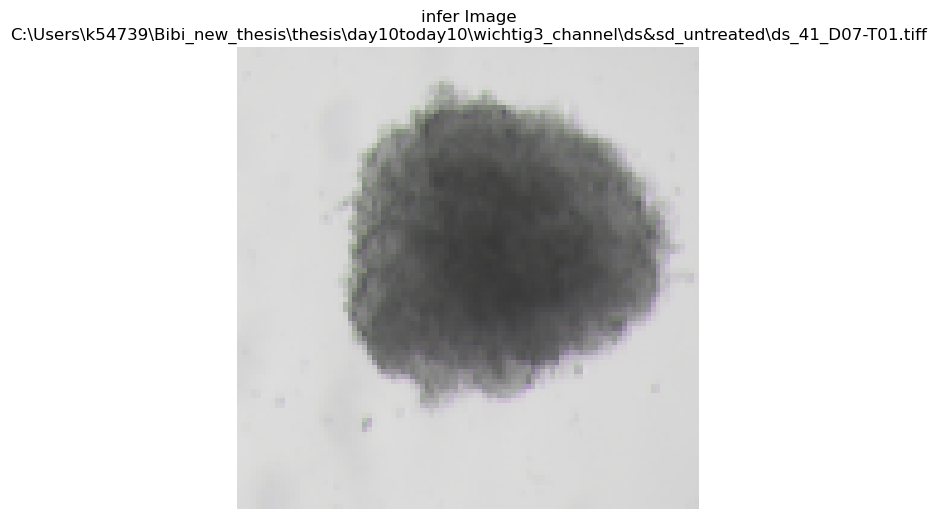

In [44]:
import matplotlib.pyplot as plt

# Retrieve a batch of augmented images
for batch_imgs, batch_paths in inference_loader:
    # Visualize the first image in the batch
    aug_img = batch_imgs[0].permute(1, 2, 0).numpy()  # Convert (C, H, W) to (H, W, C)
    #aug_img = (aug_img * 255).astype(np.uint8)  # Scale to [0, 255] for visualization

    # Display the augmented image
    plt.figure(figsize=(6, 6))
    plt.imshow(aug_img)
    plt.title(f"infer Image\n{batch_paths[0]}")
    plt.axis("off")
    plt.show()

    break  # Display only the first batch for demonstration


In [45]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    features = []
    image_paths = []

    for batch_imgs, batch_paths in tqdm(dataloader):
        # Move images to the device
        batch_imgs = batch_imgs.to(device)

        # Extract features
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")

        # Collect features and paths
        features.append(batch_feats.detach().cpu())
        image_paths.extend(batch_paths)  # Add the paths

    # Concatenate features
    features = torch.cat(features, dim=0)
    print(f"Features shape after concatenation: {features.shape}")

    return features, image_paths


In [46]:
cond10_feats, cond10_path = prepare_data_features(simclr_model, inference_loader)

  8%|▊         | 1/13 [00:00<00:09,  1.21it/s]

Batch features shape: torch.Size([16, 512])


 15%|█▌        | 2/13 [00:01<00:08,  1.25it/s]

Batch features shape: torch.Size([16, 512])


 23%|██▎       | 3/13 [00:02<00:07,  1.27it/s]

Batch features shape: torch.Size([16, 512])


 31%|███       | 4/13 [00:03<00:06,  1.32it/s]

Batch features shape: torch.Size([16, 512])


 38%|███▊      | 5/13 [00:03<00:05,  1.36it/s]

Batch features shape: torch.Size([16, 512])


 46%|████▌     | 6/13 [00:04<00:05,  1.36it/s]

Batch features shape: torch.Size([16, 512])


 54%|█████▍    | 7/13 [00:05<00:04,  1.36it/s]

Batch features shape: torch.Size([16, 512])


 62%|██████▏   | 8/13 [00:06<00:03,  1.35it/s]

Batch features shape: torch.Size([16, 512])


 69%|██████▉   | 9/13 [00:06<00:02,  1.35it/s]

Batch features shape: torch.Size([16, 512])


 77%|███████▋  | 10/13 [00:07<00:02,  1.32it/s]

Batch features shape: torch.Size([16, 512])


 85%|████████▍ | 11/13 [00:08<00:01,  1.33it/s]

Batch features shape: torch.Size([16, 512])


 92%|█████████▏| 12/13 [00:09<00:00,  1.31it/s]

Batch features shape: torch.Size([16, 512])


100%|██████████| 13/13 [00:09<00:00,  1.38it/s]

Batch features shape: torch.Size([7, 512])
Features shape after concatenation: torch.Size([199, 512])


In [47]:
import pandas as pd

# Convert features to list format for CSV
features_list = cond10_feats.numpy().tolist()  # Convert tensor to list

# Create a DataFrame
data = {
    "path": cond10_path,
    "features": features_list,
}
df = pd.DataFrame(data)

# Save to CSV
df.to_csv("cond10_feats.csv", index=False)
print("Combined dataset saved to CSV successfully.")


Combined dataset saved to CSV successfully.


In [48]:
# Load the CSV file
df = pd.read_csv("cond10_feats.csv")

# Extract paths, labels, and features
loaded_paths = df["path"].tolist()
loaded_features = torch.tensor(df["features"].apply(eval).to_list(), dtype=torch.float32)
print(df.head())
print(f"Loaded features shape: {loaded_features.shape}")
print(f"Loaded paths: {len(loaded_paths)}")



                                                path  \
0  C:\Users\k54739\Bibi_new_thesis\thesis\day10to...   
1  C:\Users\k54739\Bibi_new_thesis\thesis\day10to...   
2  C:\Users\k54739\Bibi_new_thesis\thesis\day10to...   
3  C:\Users\k54739\Bibi_new_thesis\thesis\day10to...   
4  C:\Users\k54739\Bibi_new_thesis\thesis\day10to...   

                                            features  
0  [0.8130877614021301, 2.674067974090576, 0.0, 1...  
1  [1.0998497009277344, 3.4053027629852295, 0.204...  
2  [0.0, 0.7638385891914368, 0.0, 1.8706597089767...  
3  [0.5781906247138977, 0.5684137344360352, 0.356...  
4  [0.0, 0.21554061770439148, 0.10425356775522232...  
Loaded features shape: torch.Size([199, 512])
Loaded paths: 199
